In [ ]:
import jax.numpy as jnp
import numpy as np
import os as os
import pylab as plt
import jax
import time


In [138]:
def rosenbrock(x): 
    x1, x2 = x
    return 100 * (x2 - x1 ** 2) ** 2 + (1 - x1) ** 2

In [139]:
def nes(objective_function, num_iterations, num_samples, dimension, learning_rate):
    # Initialize parameters
    mu = np.random.randn(dimension)  # Mean
    sigma = np.eye(dimension)  # Covariance matrix (identity)
    mean_trajectory = []
    covariance_trajectory = []
    
    for _ in range(num_iterations):
        # Sample from N(mu, sigma)
        z = np.random.multivariate_normal(mu, sigma, num_samples)

        # Evaluate the objective function
        fitness = np.array([objective_function(ind) for ind in z])
        
        # Rank fitness (lower is better) and normalize to calculate utilities
        ranked_indices = np.argsort(fitness)
        z = z[ranked_indices]

        # Calculate utility values for NES (rewards proportional to rank)
        utilities = np.arange(1, num_samples + 1)
        utilities = np.log(num_samples + 1) - np.log(utilities)
        utilities /= utilities.sum()  # Normalize utilities

        # Update mean
        # Calculate the gradient for the mean update
        mu_update = learning_rate * np.dot(utilities, z - mu)
        mu = mu + mu_update

        # Update covariance
        diff = z - mu
        sigma_update = learning_rate * np.sum(utilities[:, None, None] * (diff[:, :, None] @ diff[:, None, :] - sigma), axis = 0)
        sigma = sigma + 0.5 * sigma_update 

        if _ % 100 == 0:
            mean_trajectory.append(mu.copy())
            covariance_trajectory.append(sigma.copy())

    return mu, mean_trajectory, covariance_trajectory

In [152]:
num_iterations = 1000
num_samples = 100
dimension = 2         
learning_rate = 0.1 

final_mean, mean_trajectory, covariance_trajectory = nes(rosenbrock, num_iterations, num_samples, dimension, learning_rate)
print(f"Optimal Parameters: {final_mean}")

Optimal Parameters: [1.00000004 1.00000009]


In [136]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=1.0, **kwargs):
    # Get the eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    # Sort the eigenvalues in descending order
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Calculate the angle of rotation of the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Width and height of the ellipse
    width, height = 2 * nstd * np.sqrt(eigvals)
    
    # Draw the ellipse
    return Ellipse(xy=pos, width=width, height=height, angle=angle, **kwargs)

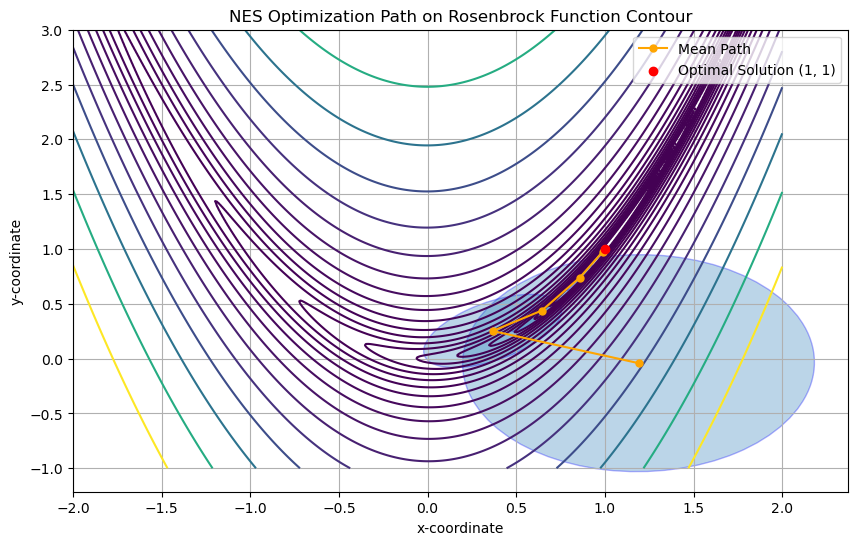

In [153]:
mean_trajectory = np.array(mean_trajectory)
covariance_trajectory = np.array(covariance_trajectory)

# Define the plot grid for the contour plot
x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.array([[rosenbrock([x, y]) for x, y in zip(row_x, row_y)] for row_x, row_y in zip(X, Y)])

# Plot the contour, mean trajectory, and covariance ellipses
plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
plt.plot(mean_trajectory[:, 0], mean_trajectory[:, 1], marker='o', markersize=5, color='orange', label='Mean Path')
plt.scatter([1], [1], color='red', label='Optimal Solution (1, 1)', zorder=5)

# Add ellipses for the covariance
for mu, cov in zip(mean_trajectory, covariance_trajectory):
    ellipse = plot_cov_ellipse(cov, mu, nstd=1, edgecolor='blue', alpha=0.3)
    plt.gca().add_patch(ellipse)

plt.title("NES Optimization Path on Rosenbrock Function Contour")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.legend()
plt.grid()
plt.show()



## Hyperparamter tuning
